In [76]:
import pandas as pd
import unicodedata
import numpy as np
from datetime import time
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-whitegrid')

In [78]:
COLONIAS = ["San Miguel Chapultepec", "Hipodromo Condesa","Condesa"]
print("Usando colonias:", COLONIAS)

Usando colonias: ['San Miguel Chapultepec', 'Hipodromo Condesa', 'Condesa']


In [80]:
#Leer archivos

df1 = pd.read_csv("../data/raw/snapshots_dia1.csv")      
df2 = pd.read_csv("../data/raw/tesis2.csv")        

# junto mis dos archivos de snapshots
merged = pd.concat([df1, df2], ignore_index=True)


merged.to_csv("../data/raw/snapshots.csv", index=False)     

len(merged)

766364

In [81]:
#Datos de viajes y cicloestaciones
viajes_df = pd.read_csv('../data/raw/viajes_04.csv', encoding='latin-1', dtype=str)
estaciones_df = pd.read_csv('../data/raw/estaciones_catalogo.csv', encoding='latin-1', dtype=str)
snaps_df= pd.read_csv('../data/raw/snapshots.csv', encoding='latin-1', dtype=str)
info_df= pd.read_csv('../data/raw/station_info.csv', encoding='latin-1', dtype=str)

In [82]:
#estandarizar columnas
def estandariza_cols(df):
    out = df.copy()
    out.columns = (
        out.columns.str.strip()
        .str.lower()
        .str.replace(r"\s+", "_", regex=True)
        .str.replace(r"[^\w]", "", regex=True)  # quita símbolos
    )
    # quita acentos 
    out.columns = [
        "".join(c for c in unicodedata.normalize("NFKD", s) if not unicodedata.combining(c))
        for s in out.columns
    ]
    return out

viajes_df     = estandariza_cols(viajes_df)
estaciones_df = estandariza_cols(estaciones_df)
snaps_df      = estandariza_cols(snaps_df)
info_df       = estandariza_cols(info_df)

# homologa nombres 
estaciones_df = estaciones_df.rename(columns={"latitud":"lat", "longitud":"lon"})


In [83]:
#station id es dif a numero de estación que es lo que usan los otros datasets por lo que hago join y luego borro station id y el resto de las columnas que no necesito
snaps_df["station_id"] = snaps_df["station_id"].str.strip()
info_df["station_id"]  = info_df["station_id"].str.strip()

snaps_enriq = snaps_df.merge(
    info_df[["station_id", "short_name"]].drop_duplicates("station_id"),
    on="station_id",
    how="left"
).rename(columns={"short_name": "num_cicloe"})


snaps_columnas_drop =["station_id","name","address","is_renting","is_returning","last_reported"]
snaps_new = snaps_enriq.drop(columns=snaps_columnas_drop, errors="ignore")

#ahora junto columnas de viajes fecha y hora en una misma date time pq es más facil de manejar y dropeo columnas genero y edad
for c in ["fecha_retiro","hora_retiro","fecha_arribo","hora_arribo"]:
    viajes_df[c] = viajes_df[c].astype(str).str.strip()

viajes_df["fecha_hora_retiro"] = pd.to_datetime(
    viajes_df["fecha_retiro"] + " " + viajes_df["hora_retiro"],
    format="%d/%m/%Y %H:%M:%S", errors="coerce"
)

viajes_df["fecha_hora_arribo"] = pd.to_datetime(
    viajes_df["fecha_arribo"] + " " + viajes_df["hora_arribo"],
    format="%d/%m/%Y %H:%M:%S", errors="coerce"
)
viajes_columnas_drop =["genero_usuario","edad_usuario","fecha_retiro","hora_retiro","fecha_arribo","hora_arribo"]
viajes_new = viajes_df.drop(columns=viajes_columnas_drop, errors="ignore")

#igual limpio estaciones y le agrego columna de capacidad ( esta en snaps )
estaciones_columnas_drop=["sistema","calle_prin","calle_secu"]
estaciones_new = estaciones_df.drop(columns=estaciones_columnas_drop, errors="ignore")

# capacity por estación (tomamos el máximo por si varía en snapshots)
snaps_new["num_cicloe"] = pd.to_numeric(snaps_new["num_cicloe"], errors="coerce")
snaps_new["capacity"]  = pd.to_numeric(snaps_new["capacity"],  errors="coerce")
cap_por_est = snaps_new.groupby("num_cicloe", as_index=False)["capacity"].max()

# join a estaciones por num_cicloe
estaciones_new["num_cicloe"] = pd.to_numeric(estaciones_new["num_cicloe"], errors="coerce")
estaciones_new = estaciones_new.merge(cap_por_est, on="num_cicloe", how="left")

cap_map = cap_por_est.set_index("num_cicloe")["capacity"]
snaps_new.head()


snaps_new["run_ts"] = pd.to_datetime(snaps_new["run_ts"], errors="coerce")

# Mantener solo servicio: 05:00–24:00 y 00:00–00:30
mask_servicio = (snaps_new["run_ts"].dt.time >= time(5,0)) | (snaps_new["run_ts"].dt.time <= time(0,30))
snaps_new = snaps_new.loc[mask_servicio].copy()



In [84]:
#limpiar columnas
def normaliza_cicloe_inplace(df, columnas):
    # permite string o lista/tupla
    if isinstance(columnas, str):
        columnas = [columnas]

    for col in columnas:
        if col not in df.columns:
            raise KeyError(f"{col} no está en df.columns")
        df[col] = (
            pd.Series(df[col], dtype="string")
              .str.strip()
              .str.replace(r"[—–−]", "-", regex=True)      
              .str.extract(r"(\d+)", expand=False)        
              .pipe(pd.to_numeric, errors="coerce")
              .astype("Int64")
        )
normaliza_cicloe_inplace(snaps_new,"num_cicloe")
normaliza_cicloe_inplace(estaciones_new,"num_cicloe")
normaliza_cicloe_inplace(viajes_new,["ciclo_estacion_retiro","ciclo_estacionarribo"])


In [85]:
viajes_new['duracion_viaje'] = (viajes_new['fecha_hora_arribo'] - viajes_new['fecha_hora_retiro']).dt.total_seconds() / 60

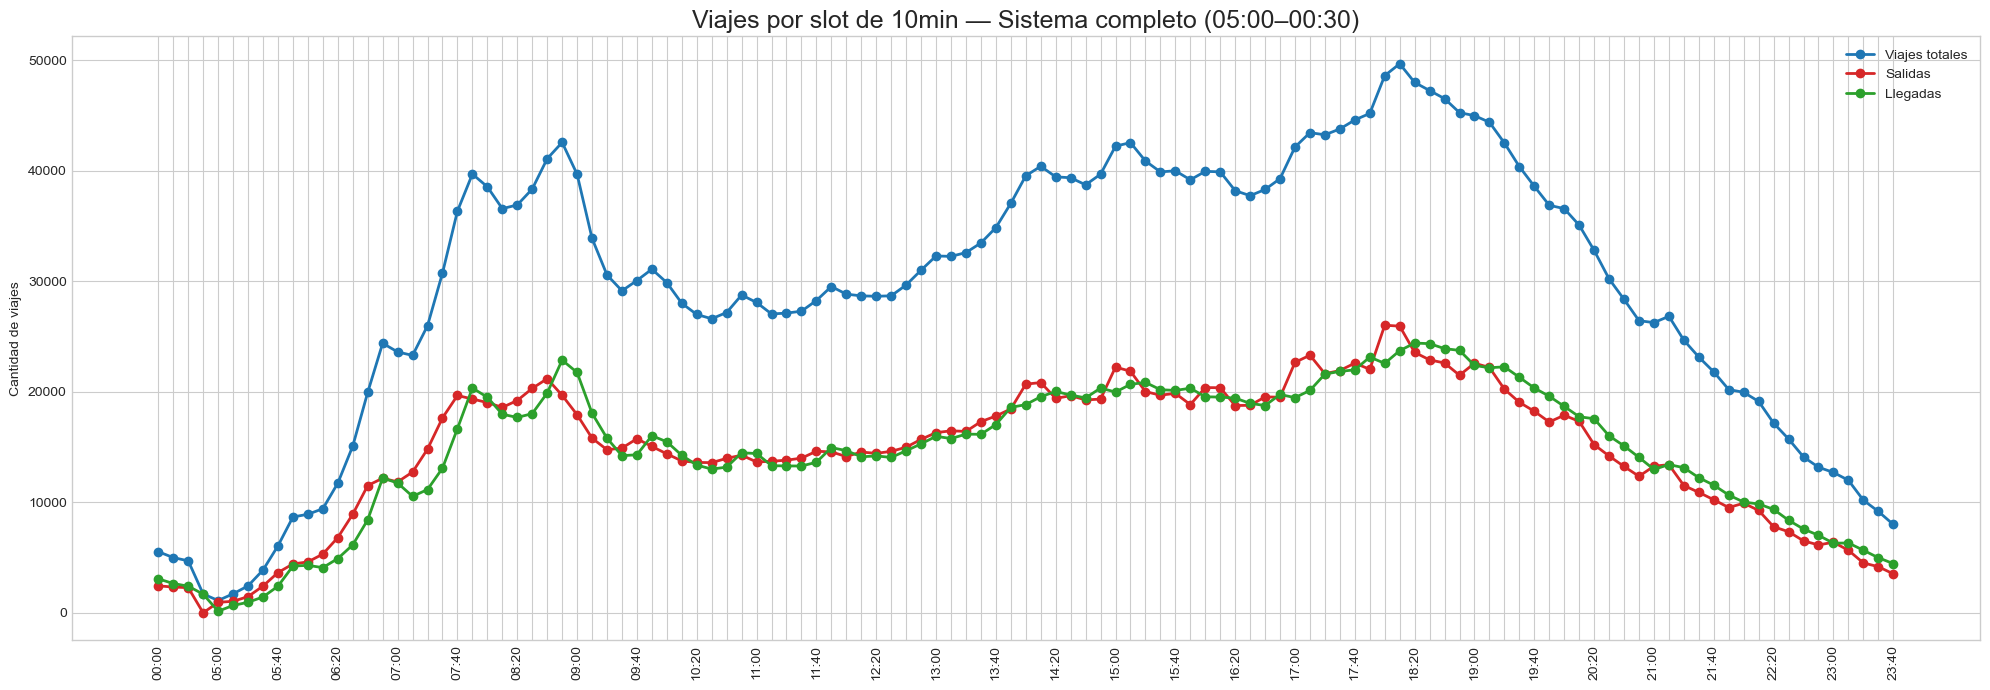

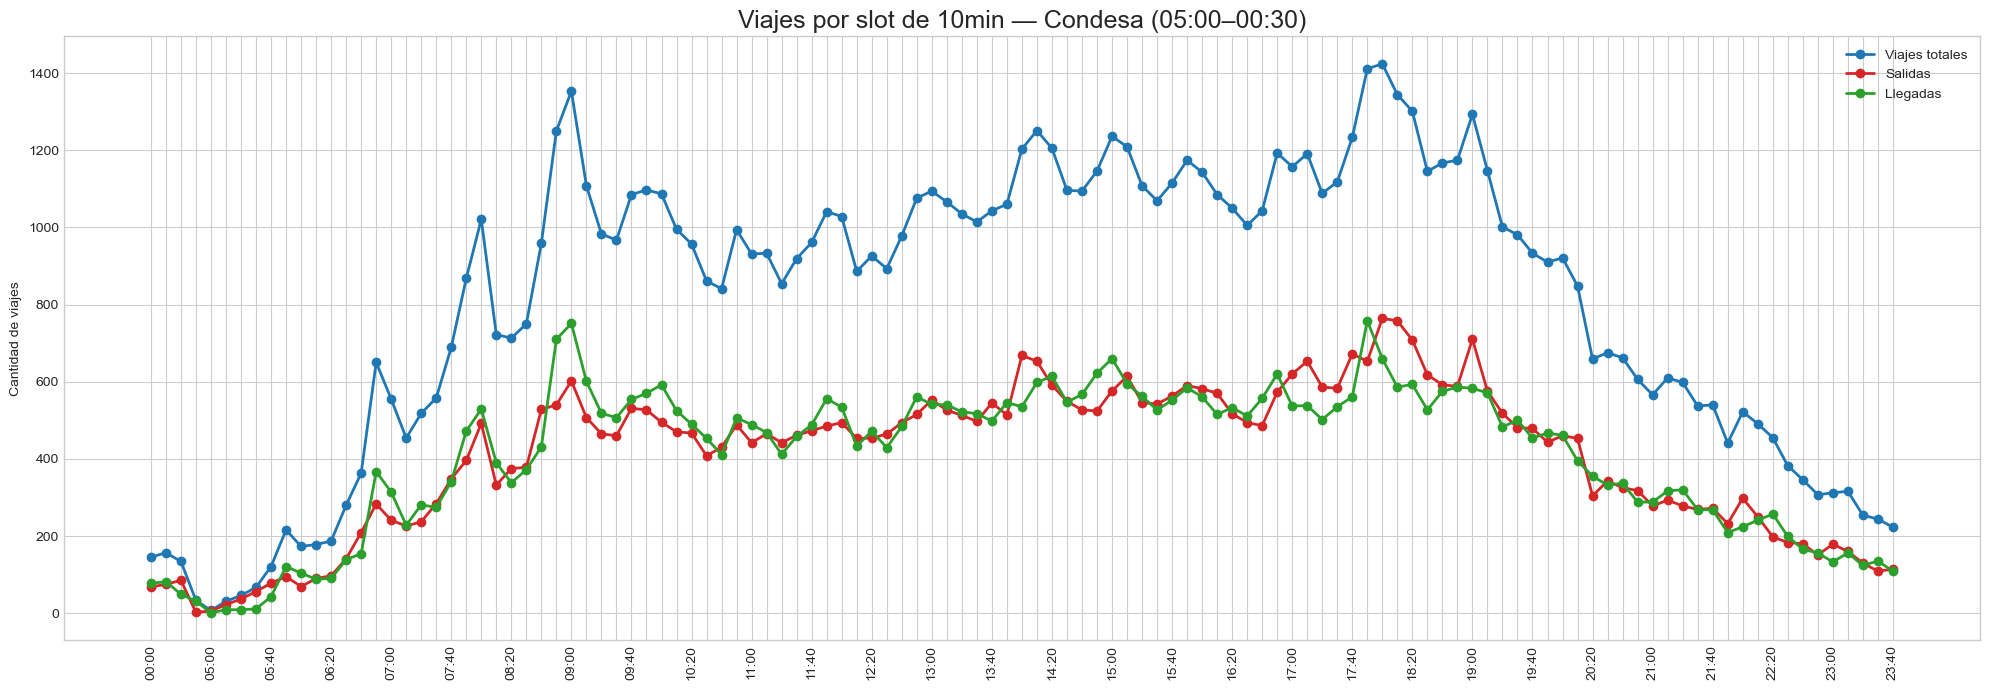

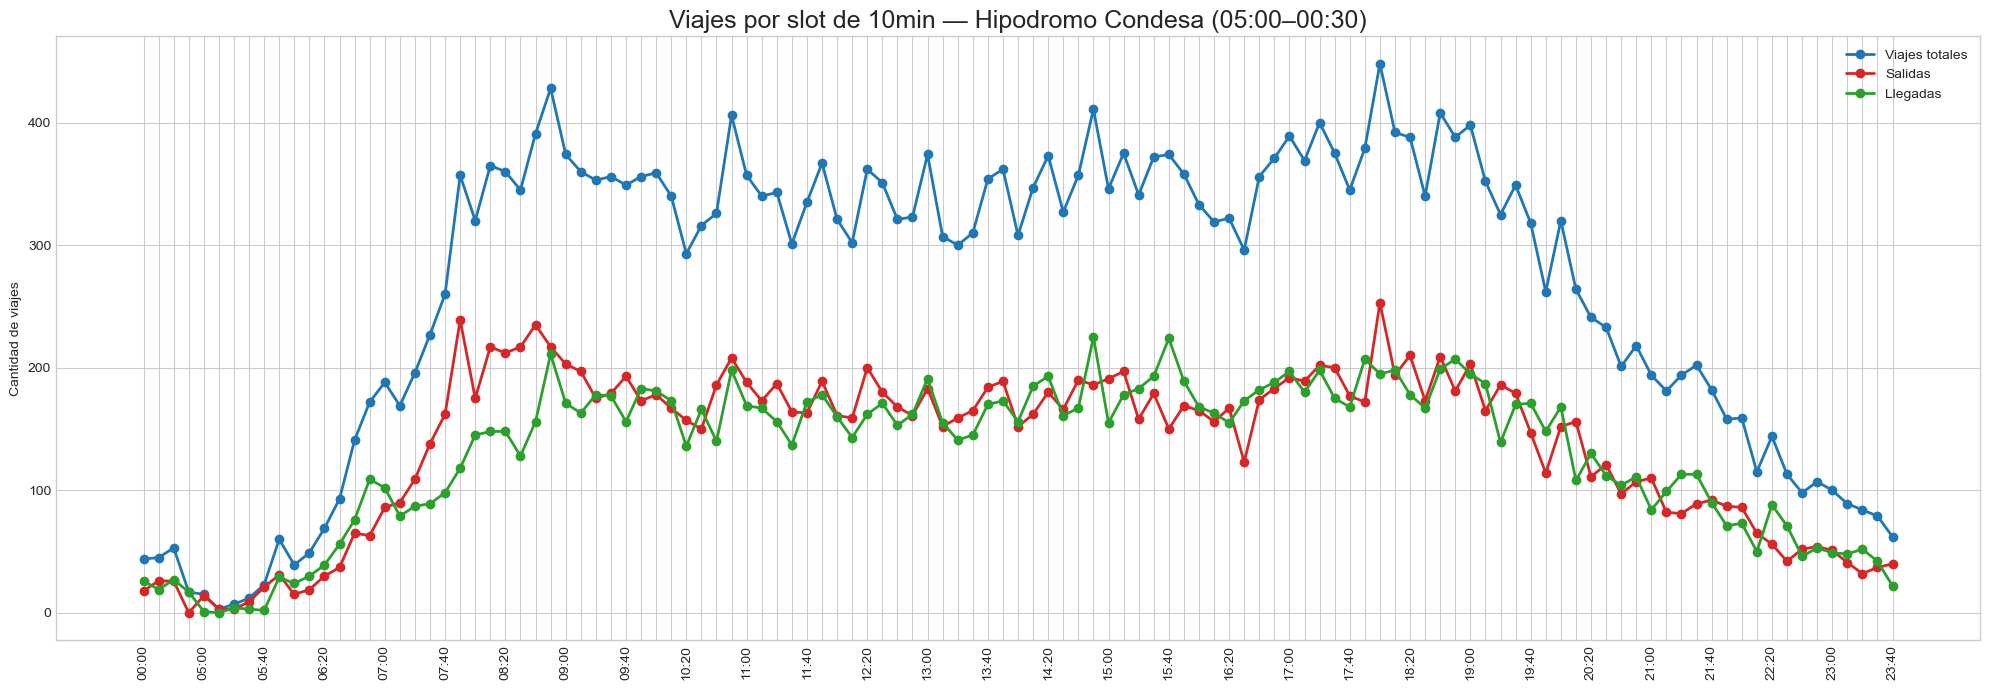

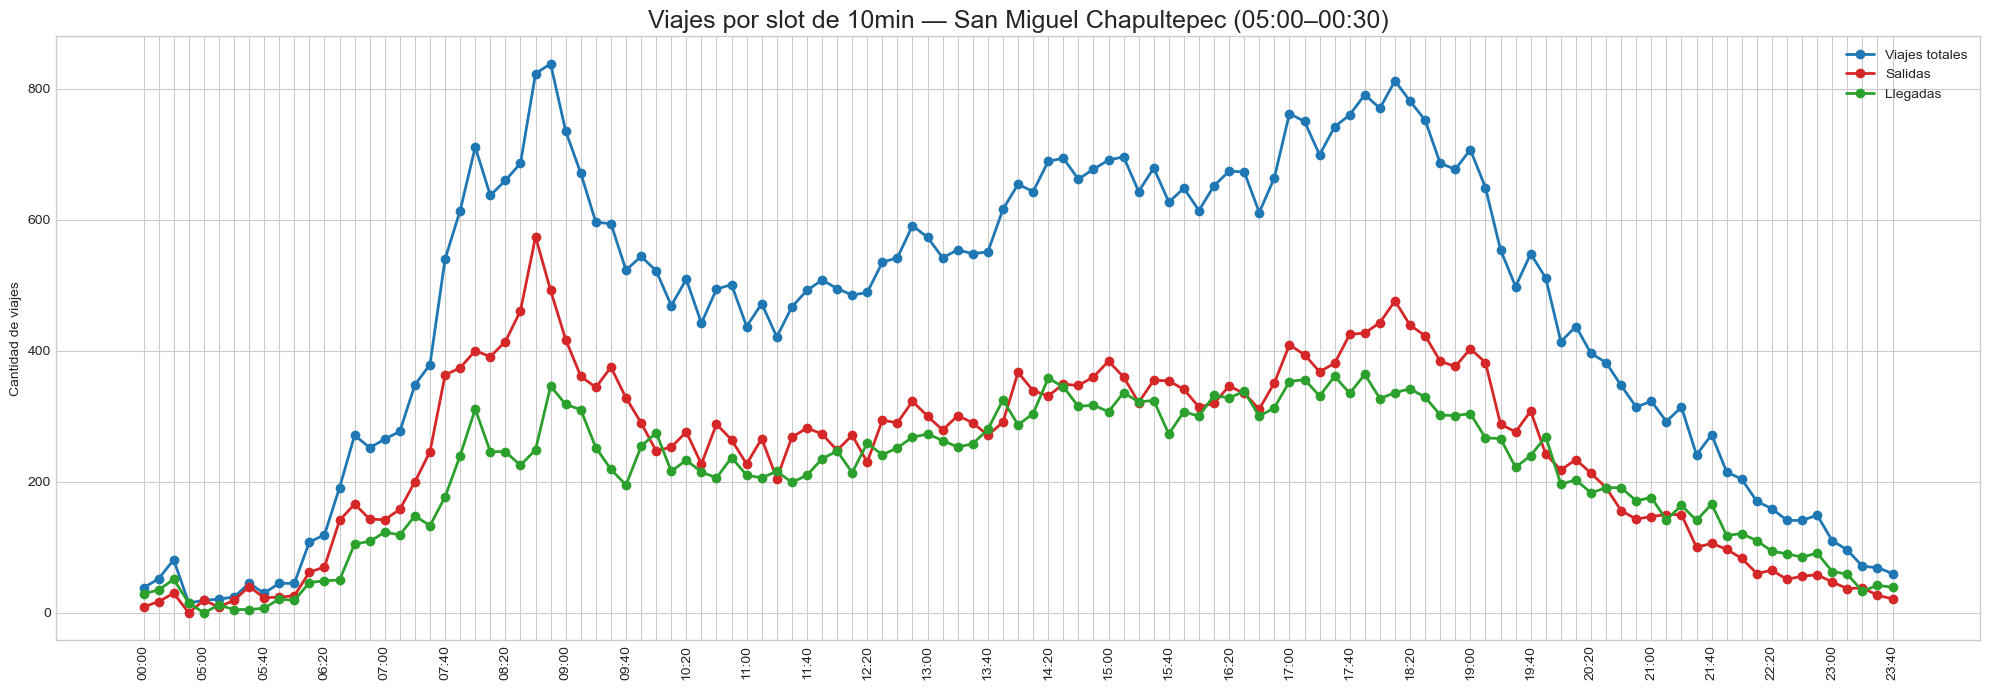

In [87]:


FREQ = "10min"   
SERVICE_START = "05:00"
SERVICE_TAIL  = ["00:00","00:10","00:20","00:30"]  # hasta 00:30

# ---- columnas y tipos ----



viajes_new["ciclo_estacion_retiro"] = pd.to_numeric(viajes_new["ciclo_estacion_retiro"], errors="coerce").astype("Int64")
viajes_new["ciclo_estacionarribo"]  = pd.to_numeric(viajes_new["ciclo_estacionarribo"], errors="coerce").astype("Int64")

estaciones_new["num_cicloe"] = pd.to_numeric(estaciones_new["num_cicloe"], errors="coerce").astype("Int64")

# HELPERS 
def service_slots(freq="15min"):
    full = pd.date_range("00:00","23:45",freq=freq).strftime("%H:%M")
    keep = [t for t in full if (t >= SERVICE_START) or (t in SERVICE_TAIL)]
    return keep

SLOTS = service_slots(FREQ)

def contar_por_slot(serie_dt):
    s = pd.Series(serie_dt.dropna(), name="fecha")
    if s.empty:
        ser = pd.Series(0, index=SLOTS)
    else:
        df = s.to_frame()
        df["slot"] = df["fecha"].dt.floor(FREQ).dt.strftime("%H:%M")
        ser = df.groupby("slot").size().reindex(SLOTS, fill_value=0)
    return ser

def eje_horas(ax):
    ax.tick_params(axis='x', rotation=90)
    labels = ax.get_xticklabels()
    for i, lbl in enumerate(labels):
        if i % 4 != 0:   # mostrar solo HH:00 (1 de cada 4 ticks de 15 min)
            lbl.set_visible(False)

def plot_tres_series(titulo, total, salidas, llegadas):
    x = list(total.index)  # "HH:MM"
    fig, ax = plt.subplots(1,1, figsize=(20,7))
    ax.plot(x, total.values,    marker='o', linewidth=2, label='Viajes totales', color='C0')  # azul
    ax.plot(x, salidas.values,  marker='o', linewidth=2, label='Salidas',        color='C3')  # rojo
    ax.plot(x, llegadas.values, marker='o', linewidth=2, label='Llegadas',       color='C2')  # verde
    ax.set_title(titulo, fontsize=18)
    ax.set_ylabel('Cantidad de viajes')
    ax.legend()
    eje_horas(ax)
    plt.tight_layout()
    plt.show()

# GRÁFICA GLOBAL 
salidas_global  = contar_por_slot(viajes_new["fecha_hora_retiro"])
llegadas_global = contar_por_slot(viajes_new["fecha_hora_arribo"])
total_global    = salidas_global.add(llegadas_global, fill_value=0)

plot_tres_series(f'Viajes por slot de {FREQ} — Sistema completo (05:00–00:30)',
                 total_global, salidas_global, llegadas_global)

# GRÁFICAS POR COLONIA 
# filtra estaciones a tus colonias objetivo
estaciones_fil = (estaciones_new[estaciones_new["colonia"].isin(COLONIAS)]
                  [["num_cicloe","colonia"]].dropna().reset_index(drop=True))

for colonia, df_est in estaciones_fil.groupby("colonia"):
    ids = set(df_est["num_cicloe"].astype(int).tolist())

    sal_mask = viajes_new["ciclo_estacion_retiro"].isin(ids)
    arr_mask = viajes_new["ciclo_estacionarribo"].isin(ids)

    salidas_c  = contar_por_slot(viajes_new.loc[sal_mask, "fecha_hora_retiro"])
    llegadas_c = contar_por_slot(viajes_new.loc[arr_mask, "fecha_hora_arribo"])
    total_c    = salidas_c.add(llegadas_c, fill_value=0)

    plot_tres_series(f'Viajes por slot de {FREQ} — {colonia} (05:00–00:30)',
                     total_c, salidas_c, llegadas_c)


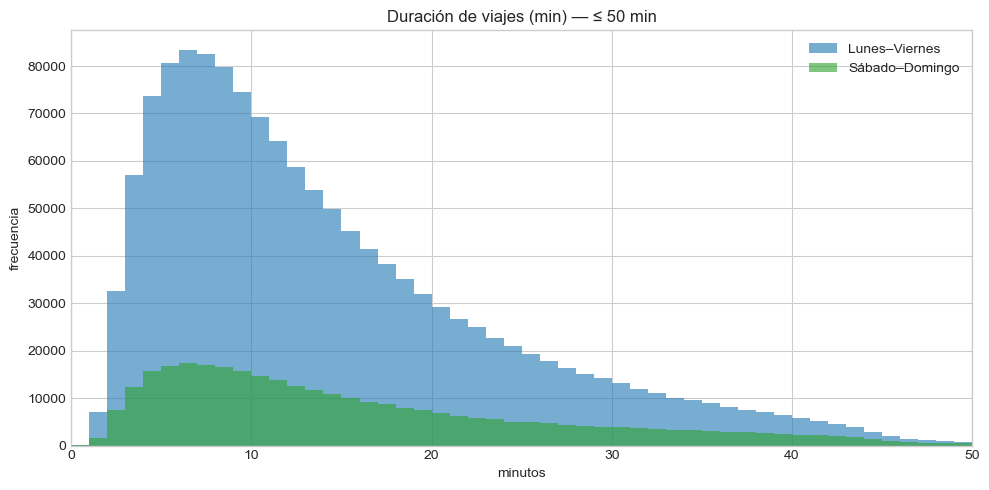

In [90]:

#  Parámetros 
CAP_MIN = 50         # max min 
BINS    = np.arange(0, CAP_MIN + 1, 1)  # bins de 1 min 


# Dur válidas  y cap a 45 min
dur = pd.to_numeric(viajes_new["duracion_viaje"], errors="coerce")
dur = dur[(dur >= 0) & (dur <= 24*60)]

#  LV/FDS por fecha de retiro
is_LV  = viajes_new["fecha_hora_retiro"].dt.dayofweek <= 4
is_FDS = ~is_LV

dur_LV  = dur[is_LV].dropna()
dur_FDS = dur[is_FDS].dropna()

# tope
dur_LV  = dur_LV[dur_LV <= CAP_MIN]
dur_FDS = dur_FDS[dur_FDS <= CAP_MIN]

#Histograma combinado
plt.figure(figsize=(10,5))
plt.hist(dur_LV,  bins=BINS, alpha=0.6, label="Lunes–Viernes", color="#1f77b4")  # azul
plt.hist(dur_FDS, bins=BINS, alpha=0.6, label="Sábado–Domingo", color="#2ca02c") # verde
plt.title(f"Duración de viajes (min) — ≤ {CAP_MIN} min")
plt.xlabel("minutos")
plt.ylabel("frecuencia")
plt.xlim(0, CAP_MIN)
plt.legend()
plt.tight_layout()
plt.show()


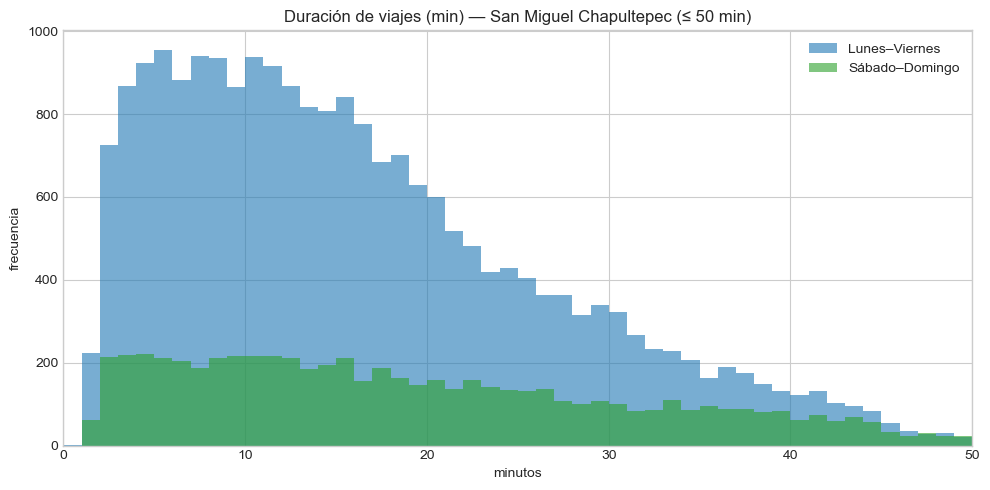

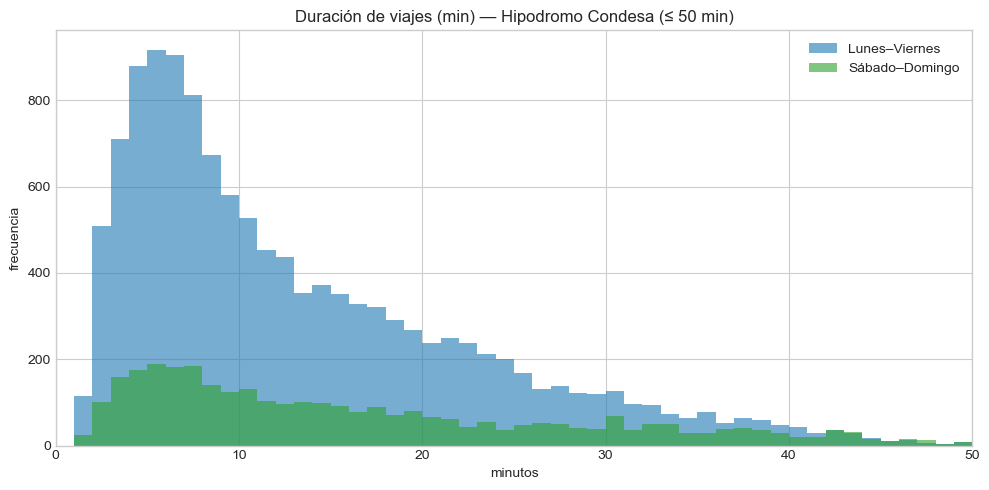

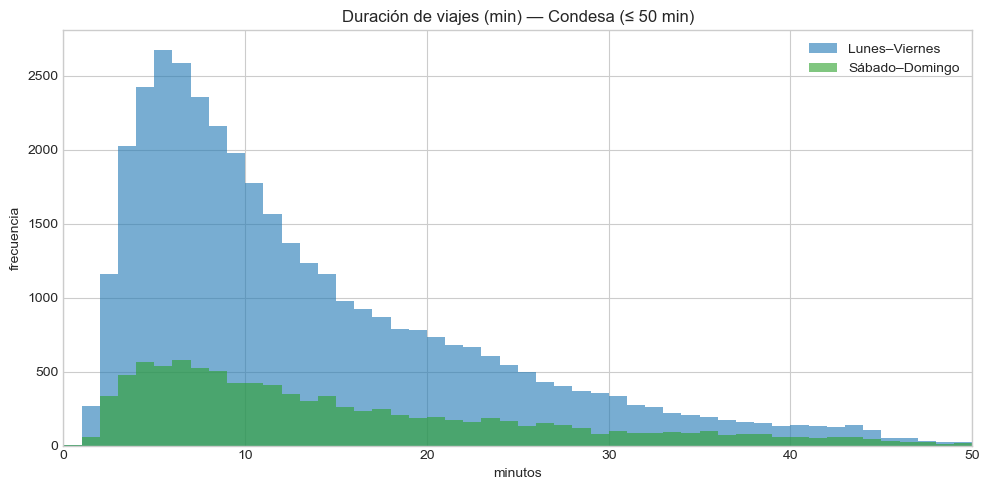

In [94]:
# colonia (para origen) ---
mapa = estaciones_new[["num_cicloe", "colonia"]].dropna()
mapa = mapa.rename(columns={"num_cicloe": "ciclo_estacion_retiro"})

# colonia_origen a viajes_new
v_col = viajes_new.merge(mapa, on="ciclo_estacion_retiro", how="left") \
                  .rename(columns={"colonia": "colonia_origen"})

#  LV vs FDS para una colonia
def hist_duracion_por_colonia(df, nombre_colonia, cap_min=45):
    sub = df[df["colonia_origen"] == nombre_colonia].copy()
    if sub.empty:
        print(f"Sin datos para {nombre_colonia}")
        return

    #  LV/FDS por fecha de retiro
    is_LV  = sub["fecha_hora_retiro"].dt.dayofweek <= 4
    is_FDS = ~is_LV

    # duraciones válidas 
    d = pd.to_numeric(sub["duracion_viaje"], errors="coerce")
    d = d[(d >= 0) & (d <= 24*60)]
    d_lv  = d[is_LV].dropna()
    d_fds = d[is_FDS].dropna()
    d_lv  = d_lv[d_lv  <= cap_min]
    d_fds = d_fds[d_fds <= cap_min]

    bins = np.arange(0, cap_min + 1, 1)

    plt.figure(figsize=(10,5))
    plt.hist(d_lv,  bins=bins, alpha=0.6, label="Lunes–Viernes", color="#1f77b4")  # azul
    plt.hist(d_fds, bins=bins, alpha=0.6, label="Sábado–Domingo", color="#2ca02c") # verde
    plt.title(f"Duración de viajes (min) — {nombre_colonia} (≤ {cap_min} min)")
    plt.xlabel("minutos")
    plt.ylabel("frecuencia")
    plt.xlim(0, cap_min)
    plt.legend()
    plt.tight_layout()
    plt.show()

# para tus colonias seleccionadas 
for col in COLONIAS:
    hist_duracion_por_colonia(v_col, col, cap_min=CAP_MIN)



In [98]:

RADIO_DENSIDAD = 300.0  # m
#me aseguro q son numericos
for c in ["lat","lon","capacity"]:
    estaciones_new[c] = pd.to_numeric(estaciones_new[c], errors="coerce")

R = 6371000.0  # m
valid = estaciones_new["lat"].notna() & estaciones_new["lon"].notna()

lat = np.radians(estaciones_new.loc[valid, "lat"].to_numpy())
lon = np.radians(estaciones_new.loc[valid, "lon"].to_numpy())

# Si capacidad tiene NA, se vuelve 0 para la suma
caps = np.nan_to_num(estaciones_new.loc[valid, "capacity"].to_numpy(dtype=float), nan=0.0)

# Distancias Haversine
dlat = lat[:, None] - lat[None, :]
dlon = lon[:, None] - lon[None, :]
a = np.sin(dlat/2)**2 + np.cos(lat)[:, None]*np.cos(lat)[None, :]*np.sin(dlon/2)**2
dist_m = 2 * R * np.arcsin(np.sqrt(a))

# Suma de capacidades dentro de 300 m (incluye la propia, dist=0)
mask = dist_m <= RADIO_DENSIDAD
dens = np.where(mask, caps[None, :], 0.0).sum(axis=1)

estaciones_new["densidad_300m"] = np.nan
estaciones_new.loc[valid, "densidad_300m"] = dens

# Si alguna fila no tiene lat/lon, al menos su propia capacidad
estaciones_new["densidad_300m"] = estaciones_new["densidad_300m"].fillna(estaciones_new["capacity"])


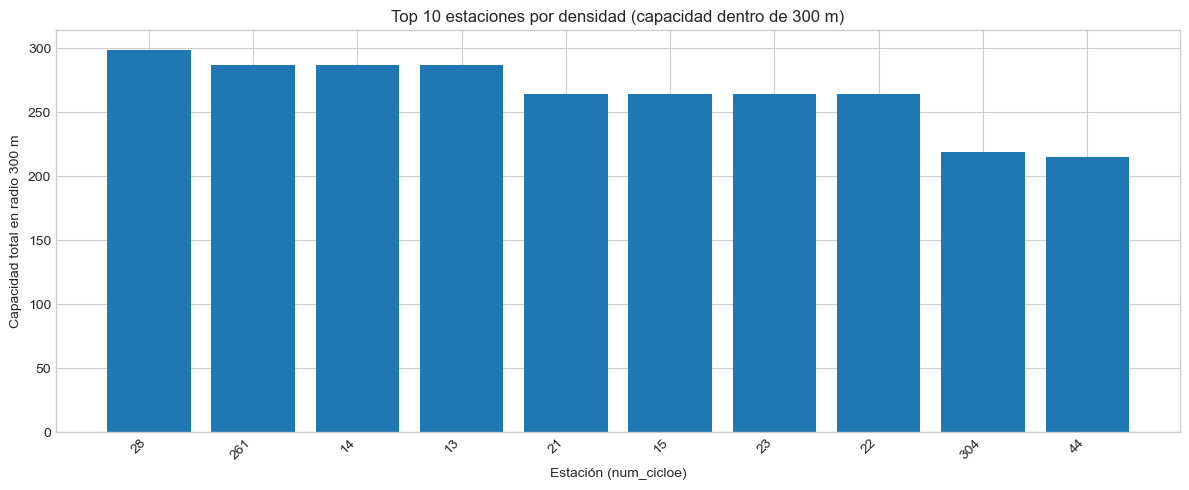

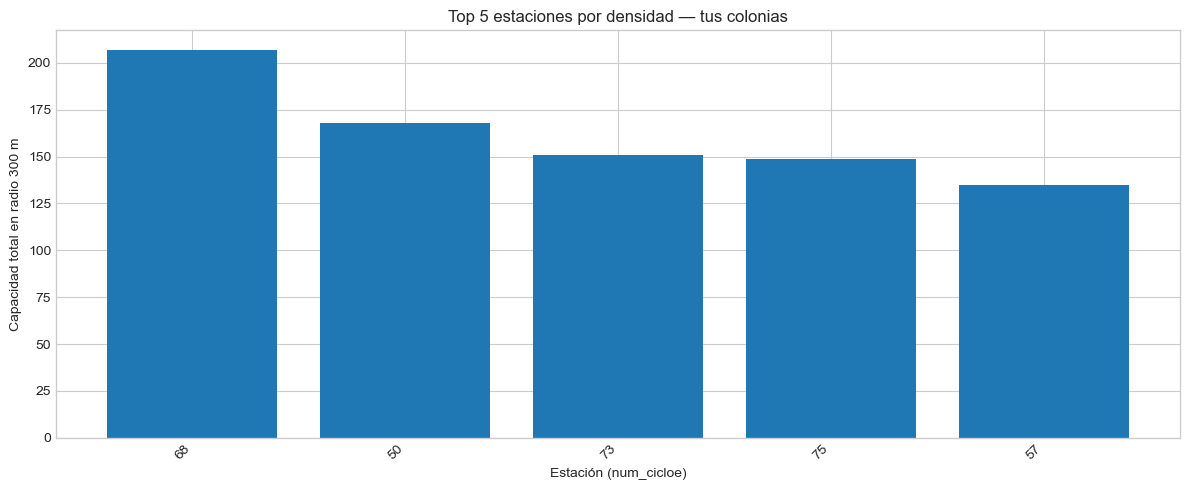

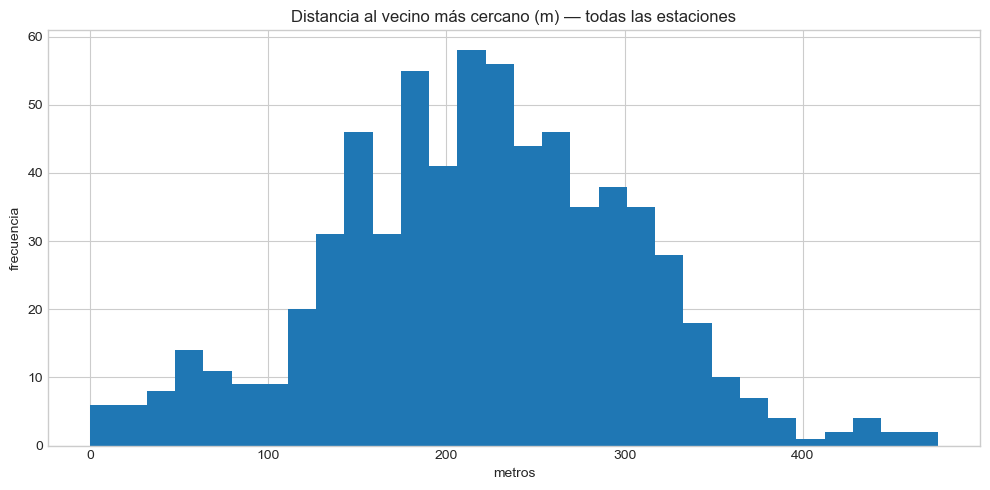

In [108]:

for c in ["lat","lon","capacity","densidad_300m"]:
    estaciones_new[c] = pd.to_numeric(estaciones_new[c], errors="coerce")

# Top 10 estaciones más densas (global) ----------
top10 = (estaciones_new
         .dropna(subset=["densidad_300m"])
         .sort_values("densidad_300m", ascending=False)
         .head(10)
         .loc[:, ["num_cicloe", "colonia", "densidad_300m"]])

plt.figure(figsize=(12,5))
plt.bar(top10["num_cicloe"].astype(str), top10["densidad_300m"])
plt.title("Top 10 estaciones por densidad (capacidad dentro de 300 m)")
plt.xlabel("Estación (num_cicloe)")
plt.ylabel("Capacidad total en radio 300 m")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# Tus colonias: Top 5 estaciones más densas 
sel = estaciones_new[estaciones_new["colonia"].isin(COLONIAS)].copy()
top5_sel = (sel.dropna(subset=["densidad_300m"])
               .sort_values("densidad_300m", ascending=False)
               .head(5)
               .loc[:, ["num_cicloe","colonia","densidad_300m"]])

plt.figure(figsize=(12,5))
plt.bar(top5_sel["num_cicloe"].astype(str), top5_sel["densidad_300m"])
plt.title("Top 5 estaciones por densidad — tus colonias")
plt.xlabel("Estación (num_cicloe)")
plt.ylabel("Capacidad total en radio 300 m")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


# Distancia al vecino más cerca

valid = estaciones_new["lat"].notna() & estaciones_new["lon"].notna()
coords = estaciones_new.loc[valid, ["lat","lon"]].to_numpy(dtype=float)

if len(coords) >= 2:
    # Haversine 
    R = 6371000.0
    lat = np.radians(coords[:,0])[:,None]
    lon = np.radians(coords[:,1])[:,None]
    dlat = lat - lat.T
    dlon = lon - lon.T
    a = np.sin(dlat/2)**2 + np.cos(lat)*np.cos(lat.T)*np.sin(dlon/2)**2
    dist = 2*R*np.arcsin(np.sqrt(a))
    # evitar 0 en diagonal para buscar el mínimo distinto de esa misma
    np.fill_diagonal(dist, np.inf)
    nearest = dist.min(axis=1)  # m

    estaciones_new.loc[valid, "dist_vecino_mas_cercano"] = nearest

    # Histograma global (distancia NN)
    vals = estaciones_new.loc[valid, "dist_vecino_mas_cercano"].dropna()
    plt.figure(figsize=(10,5))
    plt.hist(vals, bins=30)
    plt.title("Distancia al vecino más cercano (m) — todas las estaciones")
    plt.xlabel("metros"); plt.ylabel("frecuencia")
    plt.tight_layout(); plt.show()

In [110]:
def resumen_densidad(df, titulo=""):
    d = df["densidad_300m"].dropna()
    if d.empty:
        print(f"{titulo} — sin datos válidos de densidad_300m.")
        return
    mean   = d.mean()
    median = d.median()
    dmin   = d.min()
    dmax   = d.max()

    # Estaciones que alcanzan min y max (por si quieres identificar)
    est_min = df.loc[df["densidad_300m"] == dmin, ["num_cicloe","colonia"]].head(3)
    est_max = df.loc[df["densidad_300m"] == dmax, ["num_cicloe","colonia"]].head(3)

    print(f"\n{titulo}".strip())
    print("-"*max(30, len(titulo)))
    print(f"Promedio: {mean:,.2f}")
    print(f"Mediana : {median:,.2f}")
    print(f"Mínimo  : {dmin:,.2f}   -> estaciones (ejemplos): {est_min.to_dict('records')}")
    print(f"Máximo  : {dmax:,.2f}   -> estaciones (ejemplos): {est_max.to_dict('records')}")

# 1) Global (todas las estaciones)
resumen_densidad(estaciones_new, "Densidad 300m — Global")

# 2) Solo tus colonias (si tienes la lista COLONIAS definida)
if 'COLONIAS' in globals():
    sub = estaciones_new[estaciones_new["colonia"].isin(COLONIAS)]
    resumen_densidad(sub, "Densidad 300m — Tus colonias")

Densidad 300m — Global
------------------------------
Promedio: 79.39
Mediana : 69.00
Mínimo  : 0.00   -> estaciones (ejemplos): [{'num_cicloe': None, 'colonia': 'Centro'}, {'num_cicloe': None, 'colonia': 'General Pedro Maria Anaya'}]
Máximo  : 299.00   -> estaciones (ejemplos): [{'num_cicloe': 28, 'colonia': 'Juarez'}]
Densidad 300m — Tus colonias
------------------------------
Promedio: 96.61
Mediana : 93.50
Mínimo  : 29.00   -> estaciones (ejemplos): [{'num_cicloe': 185, 'colonia': 'San Miguel Chapultepec'}]
Máximo  : 207.00   -> estaciones (ejemplos): [{'num_cicloe': 68, 'colonia': 'Condesa'}]
